In [ ]:
# !pip install dotenv
# !pip install -qU langchain-tavily
# https://wikidocs.net/264624 작업


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: C:\Users\kevin\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

### 1. TavilySearchResults 검색 API 도구 사용

In [2]:
from langchain_tavily import TavilySearch

# 검색 도구 생성
tool = TavilySearch(max_results=3)

# 도구 목록에 추가
tools = [tool]

In [20]:
tool.invoke({"query": "What happened Korean President"})

{'query': 'What happened Korean President',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': "What to Know About the Removal of South Korea's President",
   'url': 'https://www.nytimes.com/2025/04/04/world/asia/yoon-south-korea-impeachment-ruling.html',
   'content': 'What to Know About South Korea President Yoon’s Impeachment Over Martial Law - The New York Times The country’s Constitutional Court on Friday upheld the impeachment of Yoon Suk Yeol, dismissing him from office four months after his short-lived imposition of martial law. South Korea’s Constitutional Court ruled unanimously to remove former President Yoon Suk Yeol. South Korea’s Constitutional Court on Friday upheld the impeachment of President Yoon Suk Yeol, removing him from office four months after his short-lived imposition of martial law on Dec. 3. Some 22 minutes later, he announced that all eight of the court’s justices had voted to remove Mr. Yoon from office. We encourage you to

In [21]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages


# State 정의
class State(TypedDict):
    # list 타입에 add_messages 적용(list 에 message 추가)
    messages: Annotated[list, add_messages]

In [ ]:
from langchain_openai import ChatOpenAI
# from langchain_community.chat_models import ChatOllama

# LLM 초기화
llm = ChatOpenAI(api_key="ollama", model="mistral:latest", base_url="http://61.108.166.16:11434")
# llm = ChatOpenAI(model="gpt-4o-mini")
# llm = ChatOllama(model="mistral:latest", base_url="http://61.108.166.16:11434")
# llm = ChatOllama(model="mistral:latest", base_url="http://ollama_dev:11434")
llm.invoke("")
# LLM 에 도구 바인딩
llm_with_tools = llm.bind_tools(tools)      # ChatOpenAI 에만 적용됨.

In [23]:
# 노드 함수 정의
def chatbot(state: State):
    answer = llm_with_tools.invoke(state["messages"])
    # 메시지 목록 반환
    return {"messages": [answer]}  # 자동으로 add_messages 적용

In [24]:
# 그래프 생성 및 노드를 추가
from langgraph.graph import StateGraph

# 상태 그래프 초기화
graph_builder = StateGraph(State)

# 노드 추가
graph_builder.add_node("chatbot", chatbot)

### 2. 도구 노드(Tool Node)
- 다음으로, 도구가 호출될 경우 실제로 실행할 수 있는 함수를 만들어야 합니다. 이를 위해 새로운 노드에 도구를 추가합니다.
- 가장 최근의 메시지를 확인하고 메시지에 tool_calls가 포함되어 있으면 도구를 호출하는 BasicToolNode를 구현
- 지금은 직접 구현하지만, 나중에는 LangGraph의 pre-built 되어있는 ToolNode 로 대체할 수 있습니다.

In [25]:
import json
from langchain_core.messages import ToolMessage


class BasicToolNode:
    """Run tools requested in the last AIMessage node"""

    def __init__(self, tools: list) -> None:
        # 도구 리스트
        self.tools_list = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        # 메시지가 존재할 경우 가장 최근 메시지 1개 추출
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")

        # 도구 호출 결과
        outputs = []
        for tool_call in message.tool_calls:
            # 도구 호출 후 결과 저장
            tool_result = self.tools_list[tool_call["name"]].invoke(tool_call["args"])
            outputs.append(
                # 도구 호출 결과를 메시지로 저장
                ToolMessage(
                    content=json.dumps(
                        tool_result, ensure_ascii=False
                    ),  # 도구 호출 결과를 문자열로 변환
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )

        return {"messages": outputs}


# 도구 노드 생성
tool_node = BasicToolNode(tools=[tool])

# 그래프에 도구 노드 추가
graph_builder.add_node("tools", tool_node)

### 3. 조건부 엣지(Conditional Edge)
1) Edges는 한 노드에서 다음 노드로 제어 흐름을 라우팅합니다.
2) Conditional edges는 일반적으로 "if" 문을 포함하여 현재 그래프 상태에 따라 다른 노드로 라우팅합니다. 
3) 이러한 함수는 현재 그래프 state를 받아 다음에 호출할 Node 를 나타내는 문자열 또는 문자열 목록 을 반환합니다.
4) 조건은 도구 호출이 있으면 tools로, 없으면 END로 라우팅


In [26]:
from langgraph.graph import START, END

# route_tools라는 라우터 함수를 정의하여 챗봇의 출력에서 tool_calls를 확인
def route_tools(
    state: State,
):
    if messages := state.get("messages", []):
        # 가장 최근 AI 메시지 추출
        ai_message = messages[-1]
    else:
        # 입력 상태에 메시지가 없는 경우 예외 발생
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    # AI 메시지에 도구 호출이 있는 경우 "tools" 반환
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        # 도구 호출이 있는 경우 "tools" 반환
        return "tools"
    # 도구 호출이 없는 경우 "END" 반환
    return END


# tools_condition 함수는 챗봇이 도구 사용을 요청하면 "tools"를 반환하고, 직접 응답이 가능한 경우 "END"를 반환
graph_builder.add_conditional_edges(
    source="chatbot",
    path=route_tools,
    # route_tools 의 반환값이 "tools" 인 경우 "tools" 노드로, 그렇지 않으면 END 노드로 라우팅
    path_map={"tools": "tools", END: END},
)

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# 그래프 컴파일
graph = graph_builder.compile()

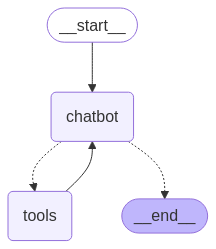

In [27]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [28]:
# from langchain_teddynote.messages import display_message_tree

# question = "한국의 다음 대통령 선거"

# for event in graph.stream({"messages": [("user", question)]}):
#     for key, value in event.items():
#         print(f"\n==============\nSTEP: {key}\n==============\n")
#         display_message_tree(value["messages"][-1])

In [29]:
question = "한국의 다음 대통령 선거"

for event in graph.stream({"messages": [("user", question)]}):
    for key, value in event.items():
        print(f"\n==============\nSTEP: {key}\n==============\n")
        # display_message_tree(value["messages"][-1])
        print(value["messages"][-1])
        # event["messages"][-1].pretty_print()

APIConnectionError: Connection error.